In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import t as t_dist

In [2]:
# Dataset is from the  National Health and Nutrition Examination Survey (NHANES) conducted by the CDC

# This file contains the collected body measurements of the participants
with open("../data/BMX_L.XPT", "rb") as f:
    df_body = pd.read_sas(f, format="xport")

# This file contains the demographic information of the participants (including age)
with open("../data/DEMO_L.XPT", "rb") as f:
    df_demo = pd.read_sas(f, format="xport")

# Merge the two dataframes by the unique identifier SEQN
df = pd.merge(df_body, df_demo, on="SEQN")

df

,SEQN,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,...,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVSTRA,SDMVPSU,INDFMPIR
0,130378.0,1.0,86.9,NaN,NaN,NaN,NaN,NaN,179.5,NaN,...,NaN,NaN,NaN,NaN,NaN,50055.450807,54374.463898,173.0,2.0,5.00
1,130379.0,1.0,101.8,NaN,NaN,NaN,NaN,NaN,174.2,NaN,...,NaN,NaN,NaN,NaN,NaN,29087.450605,34084.721548,173.0,2.0,5.00
2,130380.0,1.0,69.4,NaN,NaN,NaN,NaN,NaN,152.9,NaN,...,NaN,NaN,NaN,NaN,NaN,80062.674301,81196.277992,174.0,1.0,1.41
3,130381.0,1.0,34.3,NaN,NaN,NaN,NaN,NaN,120.1,NaN,...,2.0,2.0,2.0,3.0,NaN,38807.268902,55698.607106,182.0,2.0,1.53
4,130382.0,3.0,13.6,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,2.0,2.0,3.0,1.0,2.0,30607.519774,36434.146346,182.0,2.0,3.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8855,142306.0,1.0,25.3,NaN,NaN,NaN,NaN,NaN,128.0,NaN,...,1.0,3.0,3.0,3.0,NaN,11147.192563,13459.129019,176.0,1.0,2.01
8856,142307.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,143.8,NaN,...,NaN,NaN,NaN,NaN,NaN,69419.620456,64962.328962,181.0,1.0,NaN
8857,142308.0,1.0,79.3,NaN,NaN,NaN,NaN,NaN,173.3,NaN,...,NaN,NaN,NaN,NaN,NaN,32696.313477,44367.534132,183.0,2.0,1.95
8858,142309.0,1.0,81.9,NaN,NaN,NaN,NaN,NaN,179.1,NaN,...,NaN,NaN,NaN,NaN,NaN,30547.974564,46249.361849,176.0,1.0,3.11


In [3]:
age = df["RIDAGEYR"].to_numpy()  # age in years (capped at 80)
weight = df["BMXWT"].to_numpy()  # weight in kg
height = df["BMXHT"].to_numpy()  # height in cm
gender = df["RIAGENDR"].to_numpy()  # gender

stacked = np.stack((age, weight, height, gender), axis=1)
print(stacked.shape)
stacked = stacked[~np.isnan(stacked).any(axis=1)]
print(stacked.shape)

height = 3  # for the jointplot
joint_marginal_ratio = 4
kde_linewidth = 1.1
cond_line_width = 1.5
num_hist_bins = 25

(8860, 4)
(8471, 4)


In [4]:
# Select age ranges here
stacked_males = stacked[stacked[:, 3] == 1]
heights_young = stacked_males[stacked_males[:, 0] == 30, 2]
heights_old = stacked_males[stacked_males[:, 0] == 75, 2]

(43,)
(43,)
20-30  Mean: 176.83488372093024, Std: 8.413607022318908
75+    Mean: 170.87906976744188, Std: 7.956116796748561


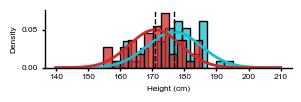

In [5]:
print(heights_young.shape)
print(heights_old.shape)

# Extract the MLE estimates for mu and sigma
mu_mle_young, sigma_mle_young = [np.mean(heights_young), np.std(heights_young)]
mu_mle_old, sigma_mle_old = [np.mean(heights_old), np.std(heights_old)]

print(f"20-30  Mean: {mu_mle_young}, Std: {sigma_mle_young}")
print(f"75+    Mean: {mu_mle_old}, Std: {sigma_mle_old}")

# Plot histogram of data with fitted Gaussian curve
x = np.linspace(140, 210, 1000)
pdf_young = (1 / (sigma_mle_young * np.sqrt(2 * np.pi))) * np.exp(
    -((x - mu_mle_young) ** 2) / (2 * sigma_mle_young**2)
)
pdf_old = (1 / (sigma_mle_old * np.sqrt(2 * np.pi))) * np.exp(
    -((x - mu_mle_old) ** 2) / (2 * sigma_mle_old**2)
)


with plt.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(figsize=(3, 1))
    g = sns.histplot(
        heights_young,
        binwidth=65 / num_hist_bins,
        ax=ax,
        stat="density",
        color="C9",
    )
    g = sns.histplot(
        heights_old,
        binwidth=65 / num_hist_bins,
        ax=ax,
        stat="density",
        color="C3",
    )
    ax.plot(x, pdf_young, label="Fitted Gaussian (MLE)", color="C9", linewidth=2)
    ax.plot(x, pdf_old, label="Fitted Gaussian (MLE)", color="C3", linewidth=2)
    ax.set_xlabel("Height (cm)")
    ax.set_ylabel("Density")

    # Add some vertical lines at the mean
    ax.axvline(mu_mle_young, color="black", linestyle="--", label="Mean (MLE)")
    ax.axvline(mu_mle_old, color="black", linestyle="--", label="Mean (MLE)")

    plt.tight_layout()
    plt.show()

# Hypothesis testing

### two-sided T-test 

In [6]:
mean_young = np.mean(heights_young)
mean_old = np.mean(heights_old)

var_young = np.var(heights_young, ddof=1)  # using ddof=1 for sample variance
var_old = np.var(heights_old, ddof=1)

n_young = len(heights_young)
n_old = len(heights_old)

pooled_std = np.sqrt(
    ((n_young - 1) * var_young + (n_old - 1) * var_old) / (n_young + n_old - 2)
)

t_stat = (mean_young - mean_old) / (pooled_std * np.sqrt(1 / n_young + 1 / n_old))

df = n_young + n_old - 2

p_value = 2 * (1 - t_dist.cdf(abs(t_stat), df))  # two-tailed test

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 3.333265260944724, P-value: 0.001278333780722507


In [7]:
# The same test using scipy.stats
# Perform t-test to compare the means of the two groups
t_stat, p_value = stats.ttest_ind(heights_young, heights_old)  # assumes equal variances
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 3.333265260944724, P-value: 0.0012783337807223943


### Permutation test

In [8]:
mean_young = np.mean(heights_young)
mean_old = np.mean(heights_old)

observed_diff = mean_young - mean_old

combined_data = np.concatenate([heights_young, heights_old])

n_permutations = 100000
permuted_diffs = []

for _ in range(n_permutations):
    np.random.shuffle(combined_data)
    permuted_group1 = combined_data[: len(heights_young)]
    permuted_group2 = combined_data[len(heights_old) :]
    permuted_diffs.append(np.mean(permuted_group1) - np.mean(permuted_group2))

p_value = np.sum(np.abs(permuted_diffs) >= np.abs(observed_diff)) / n_permutations

print(f"P-value from permutation test: {p_value}")

P-value from permutation test: 0.00134
